In [ ]:
Detecting the key drivers of customer satisfaction using customer survey data

In [1]:
import pandas as pd
import math
import numpy as np

In [3]:
data = pd.read_csv("survey_data.csv")
original_data = data
# Convert a single column from text categories to numbers
col = pd.Categorical(data["was_flight_delayed"])
data["was_flight_delayed"] = col.codes
original_data

,seat_comfort,seat_cleanliness,flight_attendant_courtesy,flight_attendant_attentiveness,food_quality,was_flight_delayed,delay_minutes,delay_handling,overall_customer_satisfaction
0,3,3,3,3,3,1,12.0,4.0,6
1,2,5,1,4,2,1,102.0,4.0,9
2,1,5,1,3,5,1,117.0,4.0,8
3,5,5,4,5,4,1,53.0,4.0,8
4,3,2,3,4,3,1,20.0,5.0,6
...,...,...,...,...,...,...,...,...,...
994,2,3,1,3,3,1,111.0,3.0,5
995,1,2,5,3,1,1,108.0,4.0,9
996,5,1,3,1,5,0,NaN,NaN,8
997,1,4,3,5,4,1,74.0,3.0,4


In [4]:
# preprocessing, delete data with missing y
print(len(data))
data.dropna(subset=['overall_customer_satisfaction'], inplace=True)
print(len(data))

999
999


In [5]:
# fill the missing values
columns = list(data.columns)[:-1]
for column in columns:
    column_mean = data[column].mean()
    data[column].fillna(column_mean, inplace=True)

In [6]:
# Min max normalization
data =(data - data.min())/(data.max() - data.min())

In [11]:
def calc_entropy(column):
    """
    Calculate entropy given a pandas series, list, or numpy array.
    """
    # Compute the counts of each unique value in the column
    counts = np.bincount(column)
    # Divide by the total column length to get a probability
    probabilities = counts / len(column)

    # Initialize the entropy to 0
    entropy = 0
    # Loop through the probabilities, and add each one to the total entropy
    for prob in probabilities:
        if prob > 0:
            entropy += prob * math.log(prob, 2)

    return -entropy

In [13]:
def calc_information_gain(data, split_name, target_name):
    """
    Calculate information gain given a data set, column to split on, and target
    """
    # Calculate the original entropy
    original_entropy = calc_entropy(data[target_name])

    # Find the median of the column we're splitting
    column = data[split_name]
    median = column.median()

    # Make two subsets of the data, based on the median
    left_split = data[column <= median]
    right_split = data[column > median]

    # Loop through the splits and calculate the subset entropies
    to_subtract = 0
    for subset in [left_split, right_split]:
        prob = (subset.shape[0] / data.shape[0])
        to_subtract += prob * calc_entropy(subset[target_name])

    # Return information gain
    return original_entropy - to_subtract

In [14]:
information_gains = []
# Loop through and compute information gains
for col in columns:
    information_gain = calc_information_gain(data, col, "overall_customer_satisfaction")
    information_gains.append(information_gain)

In [15]:
# Find the name of the column with the highest gain
highest_gain_index = information_gains.index(max(information_gains))
highest_gain = columns[highest_gain_index]

print('Most impactful feature:', highest_gain)


Most impactful feature: delay_handling


In [16]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(random_state=42, min_samples_split=10)
clf.fit(data[columns], data["overall_customer_satisfaction"])

predictions = clf.predict(data[columns])

importance = clf.feature_importances_

seat_comfort 0.1609736564747845 2.994994994994995
seat_cleanliness 0.005572221724670385 3.046046046046046
flight_attendant_courtesy 0.15341867350413207 3.039039039039039
flight_attendant_attentiveness 0.0059275038573389175 2.995995995995996
food_quality 0.0534198581988343 3.091091091091091
was_flight_delayed 0.0007321826799208728 0.6956956956956957
delay_minutes 0.1941093266074462 61.35251798561202
delay_handling 0.4258465769528727 3.5582733812949536


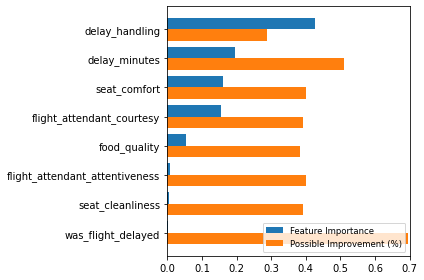

In [18]:
for i in range(len(columns)):
    print(columns[i], importance[i], original_data[columns[i]].mean())

importance_df = pd.DataFrame(data=columns, columns=['feature'])
importance_df['importance'] = importance

# we can calculate room for improvement by measuring the distance from mean to max
# we want to minimize was_flight_delayed and delay_minutes, so room for improvement should be calculated to min
improvement = []
for i in range(len(importance_df)):
    dummy = (original_data[importance_df.iloc[i]['feature']].max() - original_data[importance_df.iloc[i]['feature']].mean()) / original_data[importance_df.iloc[i]['feature']].max()
    if importance_df.iloc[i]['feature'] in ['was_flight_delayed', 'delay_minutes']:
        improvement.append(1-dummy)
    else:
        improvement.append(dummy)

importance_df['room for improvement'] = improvement

# print(original_data[columns].max())
importance_df.sort_values(by=['importance'], inplace=True)
import matplotlib.pyplot as plt
fig = plt.figure()
y_range = np.arange(len(columns))
plt.barh(y_range + 0.2, importance_df['importance'], 0.4, label='Feature Importance')
plt.barh(y_range - 0.2, importance_df['room for improvement'], 0.4, label='Possible Improvement (%)')
plt.yticks(y_range, importance_df['feature'])
plt.xlim([0,0.7])
plt.legend(loc='lower right', fontsize=8.5)
plt.tight_layout()
plt.show()

It is  shown that delay handling, delay minutes, seat
comfort, and flight attendance courtesy are more important, then food quality.  